In [29]:
import pandas as pd
from Utils import downcast
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

### 1.0 Read Data

In [56]:
df = pd.read_excel("Reporte de Anticipos.xlsx")

In [58]:
df.columns

Index(['FechaApp', 'Id_URS_PR', 'FechaNacimiento', 'Id_CTL_EDO', 'MONTO',
       'Fecha', 'ID', 'FechaRegistro', 'FechaActualizacion', 'Id_ANT_PR',
       'Id_URS_PR.1', 'Id_TTS_PX', 'Id_CTS_FS', 'Monto', 'Comision', 'IVA',
       'TotalAPagar', 'Cobrado', 'Id_CTL_ANT_ET', 'IdAgente',
       'IdAgenteActualiza', 'Visible', 'Activo', 'CSexo', 'CEstado',
       'CFechaNacimiento'],
      dtype='object')

In [ ]:

(
    df
    [["Id_URS_PR", "Id_ANT_PR", "FechaApp", "FechaNacimiento", "Id_CTL_EDO", "CEstado", "CSexo", "Fecha", "MONTO", "Monto", "FechaRegistro", "FechaActualizacion"]]
    .rename(columns={
        "Id_URS_PR": "id_usuario",
        "Id_ANT_PR": "id_prestamo",
        "FechaApp": "fecha_registro_app",
        "FechaNacimiento": "fecha_nacimiento",
        "Id_CTL_EDO": "id_estado",
        "CEstado": "estado_nacimiento",
        "CSexo": "sexo",
        "Fecha": "fecha_salario",
        "MONTO": "salario",
        "Monto": "prestamo",
        "FechaRegistro": "fecha_aprobacion",
        "FechaActualizacion": "ultima_actualizacion"
    })
    .head()
)

,id_usuario,id_prestamo,fecha_registro_app,fecha_nacimiento,id_estado,estado_nacimiento,genero,fecha_salario,salario,prestamo,fecha_aprobacion,ultima_actualizacion
0,84583,29330,2021-11-22 21:17:07.043,1995-01-19,15,JC,H,2023-04-12,673.659973,301,2023-04-20 15:21:57.543,2023-04-20 15:21:58.590
1,84583,29330,2021-11-22 21:17:07.043,1995-01-19,15,JC,H,2023-04-20,994.260010,301,2023-04-20 15:21:57.543,2023-04-20 15:21:58.590
2,84583,29330,2021-11-22 21:17:07.043,1995-01-19,15,JC,H,2023-04-05,994.059998,301,2023-04-20 15:21:57.543,2023-04-20 15:21:58.590
3,84583,29330,2021-11-22 21:17:07.043,1995-01-19,15,JC,H,2023-04-03,1350.000000,301,2023-04-20 15:21:57.543,2023-04-20 15:21:58.590
4,334,29327,2020-08-04 12:17:55.137,1998-08-10,14,JC,M,2023-04-14,3782.659912,1300,2023-04-20 14:29:54.927,2023-04-20 14:29:55.940


#### 1.1 - Downcast

In [3]:
df = downcast(df)

### 2.0 Remove non-useful rows

#### 2.1 - 18 years or older

In [4]:
# CFechaNacimiento < '2005 01 01'
df = df[df['CFechaNacimiento'] < '2005 01 01']

#### 2.2 - Error while registering

In [5]:
# FechaActualizacion - FechaRegistro < 1 day & Cobrado != 0
df = df.query("~(FechaActualizacion - FechaRegistro < '1 day' and Cobrado != 0)")

#### 2.3 - Due date not captured in the report

In [6]:
# Remove entries with date 50 days before 2023-04-25
df = df[df.FechaRegistro < datetime(2023, 4, 25) - pd.Timedelta(days=50)]

### 3.0 Add probably useful features

In [7]:
df = (
    df
    .assign(
        Edad = lambda k: (datetime.today() - k.CFechaNacimiento).dt.days / 365.25,
        TiempoAnticipo = lambda k: (k.FechaActualizacion - k.FechaRegistro),
        TiempoEnApp = lambda k: (k.FechaRegistro - k.FechaApp).dt.days,
        RegistroDif = lambda k: (k.Fecha - k.FechaRegistro).dt.days
    )
    # to get the last day of payment to user
    .assign(
        RegistroDif = lambda k: np.where(k.RegistroDif > 0, 1000, -k.RegistroDif) 
    )
)

In [8]:
# Each loan is paid only once. Important in 5.0
df.groupby("Id_ANT_PR").agg({"Cobrado": "nunique"}).reset_index().query("Cobrado > 1")

,Id_ANT_PR,Cobrado


In [9]:
# Each loan is updated only once. Important in 5.0
df.groupby("Id_ANT_PR").agg({"FechaActualizacion": "nunique"}).reset_index().query("FechaActualizacion > 1")

,Id_ANT_PR,FechaActualizacion


### 4.0 Get average income from user by month

In [10]:
df_simp = (
    df
    .groupby("Id_ANT_PR")
    .agg(
        User_Id = ("Id_URS_PR", "first"),
        Gender = ("CSexo", "first"),
        BirthState = ("CEstado", "first"),
        State_Id = ("Id_CTL_EDO", "first"),
        TimeInApp = ("TiempoEnApp", "last"),
        Age = ("Edad", "first"),
        SalaryByPeriod = ("MONTO", "mean"),
        Pay_rate = ("Fecha", "count"),
        ClosestPay = ("RegistroDif", "min"),
        loan_amount = ("Monto", "first"),
        topay_amount = ("TotalAPagar", "first"),
        paid_amount = ("Cobrado", "last"),
        RegistrationDate = ("FechaRegistro", "first"),
        LastUpdate = ("FechaActualizacion", "last"),
        TimediffUpdate = ("TiempoAnticipo", "first"),
    )
    .reset_index()
)

### 5.0 Paid/Unpaid ratio

In [11]:
df_simp = (
    df_simp
    .assign(
        Paid = lambda k: np.where(k.paid_amount < k.topay_amount, 0, 1),
    )
    .assign(
        Paid = lambda k: np.where(k.TimediffUpdate > '35 days', 0, k.Paid),
    )
)

### 6.0 rate of payment (7, 15, 30)

In [12]:
df_simp = (
    df_simp
    .assign(
        Pay_rate = lambda k: np.where(k.Pay_rate == 1, 30, 
                            np.where(k.Pay_rate.isin([2, 3]), 15,
                            np.where(k.Pay_rate > 3, 7, 0)))
    )
)

### 7.0 Not paid

In [13]:
# Update LastUpdate and TimediffUpdate if FechaActualizacion - FechaRegistro < 1 day

df_simp = (
    df_simp
    .assign(
        LastUpdate = lambda k: np.where(
            (k.ClosestPay == 1000) & (k.TimediffUpdate < '1 day'),
            k.RegistrationDate.astype("datetime64[M]") + pd.Timedelta(days=14),
            np.where(
                (k.ClosestPay != 1000) & (k.TimediffUpdate < '1 day'),
                k.LastUpdate - pd.to_timedelta(k.ClosestPay, unit='D') + pd.to_timedelta(k.Pay_rate, unit='D'),
                k.LastUpdate
            )
        ),
        TimediffUpdate = lambda k: k.LastUpdate - k.RegistrationDate
    )
    .assign(
        LastUpdate = lambda k: np.where(
            k.TimediffUpdate < '1 day',
            k.RegistrationDate + pd.Timedelta(days=1),
            k.LastUpdate
        ),
        TimediffUpdate = lambda k: k.LastUpdate - k.RegistrationDate
    )
)

In [14]:
df_simp.query("TimediffUpdate < '1 day'")

,Id_ANT_PR,User_Id,Gender,BirthState,State_Id,TimeInApp,Age,SalaryByPeriod,Pay_rate,ClosestPay,loan_amount,topay_amount,paid_amount,RegistrationDate,LastUpdate,TimediffUpdate,Paid


### 8.0 Add financial features

In [15]:
df_simp = (
    df_simp
    .assign(
        loan_num = lambda k: k.groupby("User_Id").Id_ANT_PR.transform("count"),
        annual_interest_rate_per = lambda k: 0.06*(360/k.TimediffUpdate.dt.days),
        loan_rate_salary = lambda k: k.topay_amount/k.SalaryByPeriod
    )
)

### 9.0 Remove anomalous values

In [16]:
df_simp[["loan_num", "annual_interest_rate_per", "loan_rate_salary"]].describe()

,loan_num,annual_interest_rate_per,loan_rate_salary
count,19815.000000,19814.000000,19815.000000
mean,29.715720,3.914598,15.435164
std,19.442453,4.356371,961.943481
min,1.000000,0.041699,0.000123
25%,14.000000,1.542857,0.154953
50%,27.000000,2.400000,0.242334
75%,43.000000,4.320000,0.309717
max,95.000000,21.600000,65379.000000


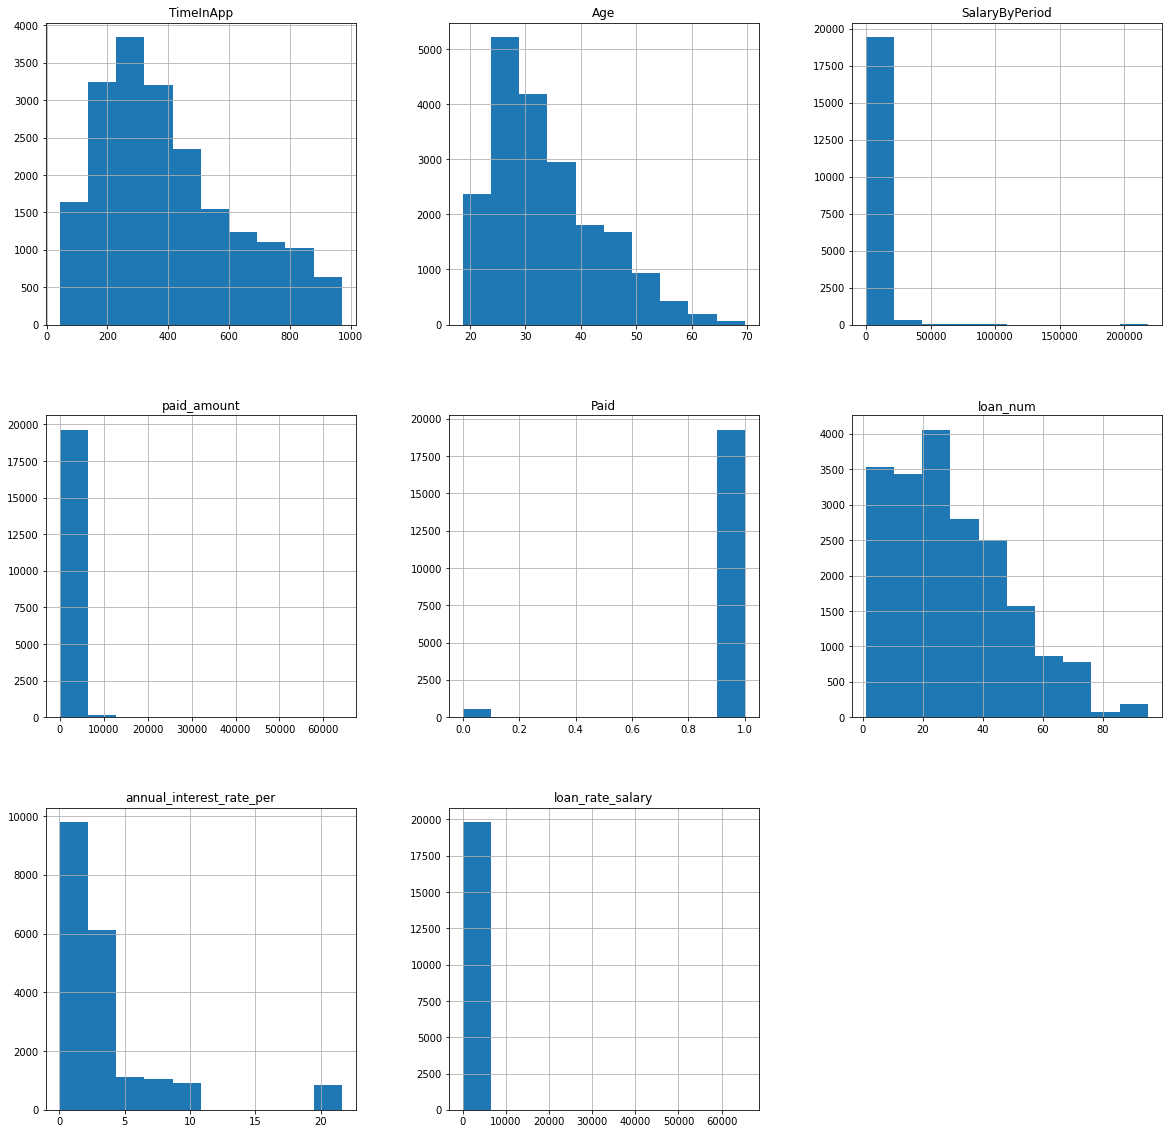

In [17]:
(
    df_simp
    [['TimeInApp', 'Age', 'SalaryByPeriod',
      'paid_amount',
      'Paid', 'loan_num', 'annual_interest_rate_per',
       'loan_rate_salary']]
    .hist(figsize=(20, 20))
);

In [18]:
# The only that I consider to be a problem is the loan_rate_salary
# loan_rate_salary < 1

In [19]:
# check the fourth quartile of loan_rate_salary
print("Q3 and Q4 of loan_rate_salary")
display(df_simp.loan_rate_salary.quantile([0.75, 1]))
# check 3 std of loan_rate_salary
print("3 std of loan_rate_salary")
df_simp.loan_rate_salary.mean() + 3*df_simp.loan_rate_salary.std()

Q3 and Q4 of loan_rate_salary


0.75        0.309717
1.00    65379.000000
Name: loan_rate_salary, dtype: float64

3 std of loan_rate_salary


2901.2656087875366

#### 9.1 - Update loan_rate_salary

In [20]:
df_simp = df_simp.query("loan_rate_salary <= 1")

### 10.0 - Feature Engineering

In [21]:
state_dict = {
    'AS': 1, 'BC': 2, 'BS': 3, 'CC': 4, 'CH': 5, 'CL': 6,
    'CS': 7, 'DF': 8, 'DG': 9, 'GR': 10, 'GT': 11, 'HG': 12,
    'JC': 13, 'MC': 14, 'MN': 15, 'MS': 16, 'NE': 17, 'NL': 18,
    'NT': 19, 'OC': 20, 'PL': 21, 'QR': 22, 'QT': 23, 'SL': 24,
    'SP': 25, 'SR': 26, 'TC': 27, 'TL': 28, 'TS': 29, 'VZ': 30,
    'YN': 31, 'ZS': 32
}

#### 10.1 - BirthState and Gender to numeric

In [22]:
df_model = (
    df_simp
    .assign(
        BirthState = lambda k: k.BirthState.map(state_dict).astype(int),
        # batos (0), morras (1)
        Gender = lambda k: k.Gender.astype("category").cat.codes,
    )
)

#### 10.2 - Select features

In [23]:
df_model = (
  df_model
  [[
      'Gender', 'BirthState', 'State_Id', 'TimeInApp', 'Age',
      'paid_amount', 'Paid', 'loan_num', 'annual_interest_rate_per', 'loan_rate_salary'
  ]]
)

### 10.3 - Feature transformation

- TimeInApp

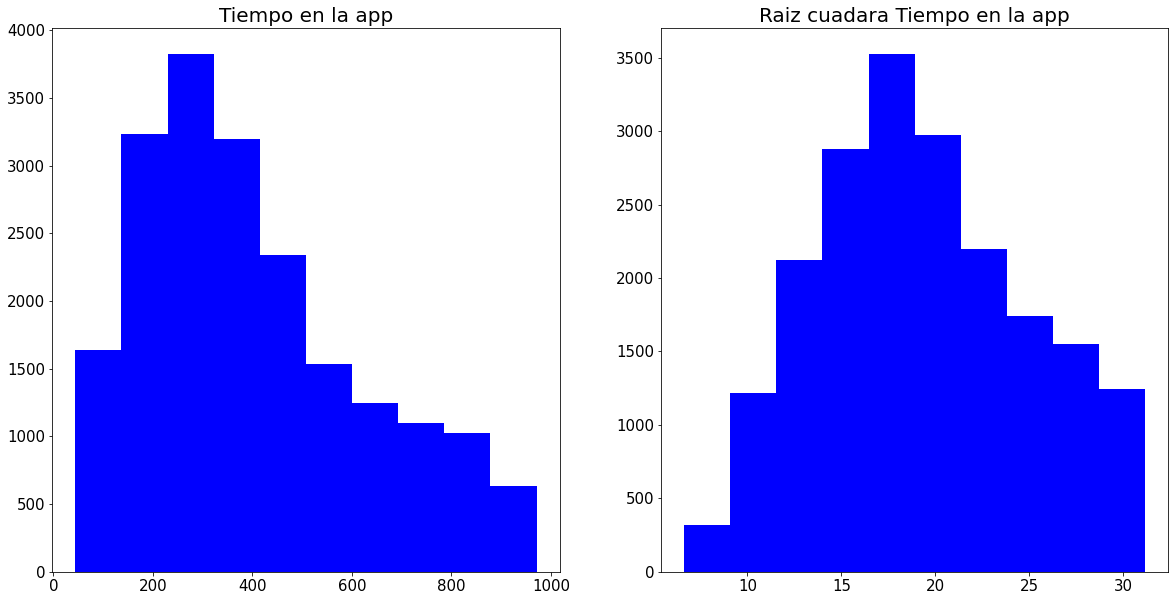

In [54]:
ll = (
    df_model
    .assign(Raiz_cuadrada_TimeInApp = lambda k: np.sqrt(k.TimeInApp))
    [['TimeInApp', 'Raiz_cuadrada_TimeInApp']]
)

#  histogram of TimeInApp and Raiz_cuadrada_TimeInApp
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(ll.TimeInApp, bins=10, color="blue")
ax[0].set_title("Tiempo en la app", fontsize=20)
ax[1].hist(ll.Raiz_cuadrada_TimeInApp, bins=10, color="blue")
ax[1].set_title("Raiz cuadara Tiempo en la app", fontsize=20)
# increase the tick size
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)

- Age

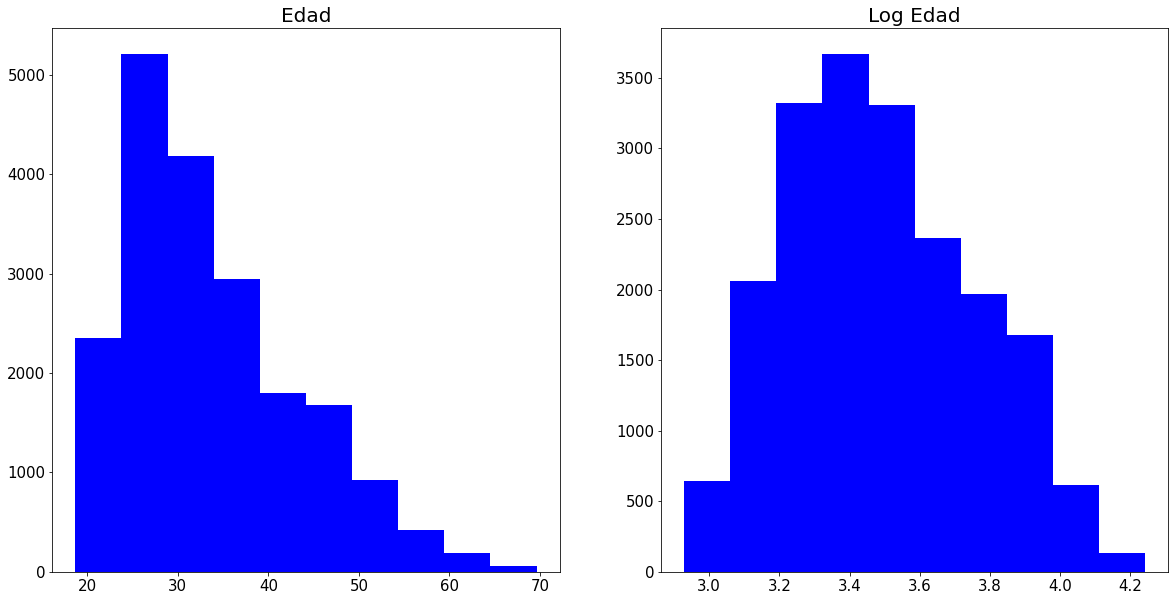

In [55]:
ll = (
    df_model
    .assign(Age_ = lambda k: np.log(k.Age))
    [['Age_', 'Age']]
)

#  histogram of Age and Age_
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(ll.Age, bins=10, color="blue")
ax[0].set_title("Edad", fontsize=20)
ax[1].hist(ll.Age_, bins=10, color="blue")
ax[1].set_title("Log Edad", fontsize=20)
# increase the tick size
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)

- paid_amount

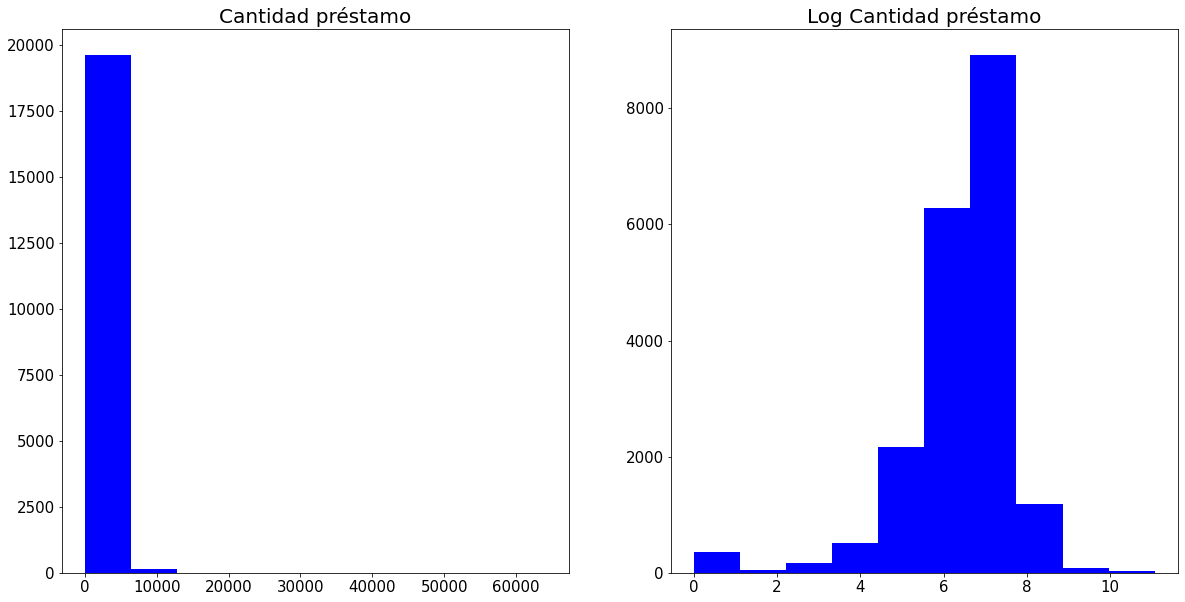

In [79]:
ll = (
    df_model
    .assign(paid_amount_ = lambda k: np.log(k.paid_amount + 1))
    [['paid_amount_', 'paid_amount']]
);

#  histogram of paid_amount and paid_amount_
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(ll.paid_amount, bins=10, color="blue")
ax[0].set_title("Cantidad préstamo", fontsize=20)
ax[1].hist(ll.paid_amount_, bins=10, color="blue")
ax[1].set_title("Log Cantidad préstamo", fontsize=20)
# increase the tick size
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)

- loan_num

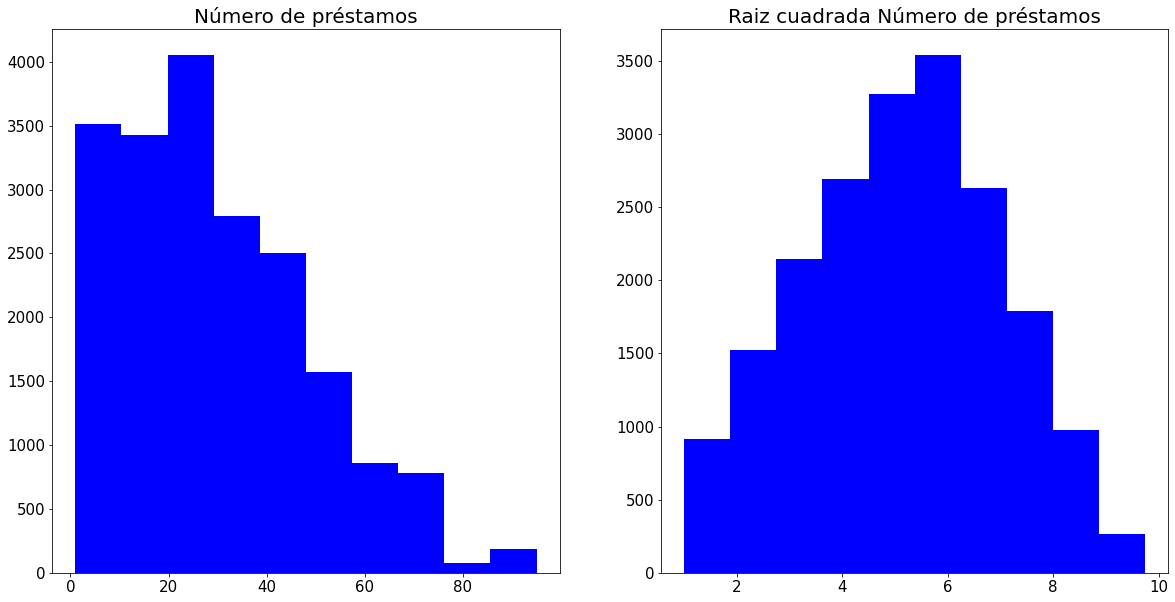

In [82]:
ll = (
    df_model
    .assign(loan_num_ = lambda k: np.sqrt(k.loan_num))
    [['loan_num_', 'loan_num']]
)

#  histogram of loan_num and loan_num_
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(ll.loan_num, bins=10, color="blue")
ax[0].set_title("Número de préstamos", fontsize=20)
ax[1].hist(ll.loan_num_, bins=10, color="blue")
ax[1].set_title("Raiz cuadrada Número de préstamos", fontsize=20)
# increase the tick size
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)

- annual_interest_rate_per

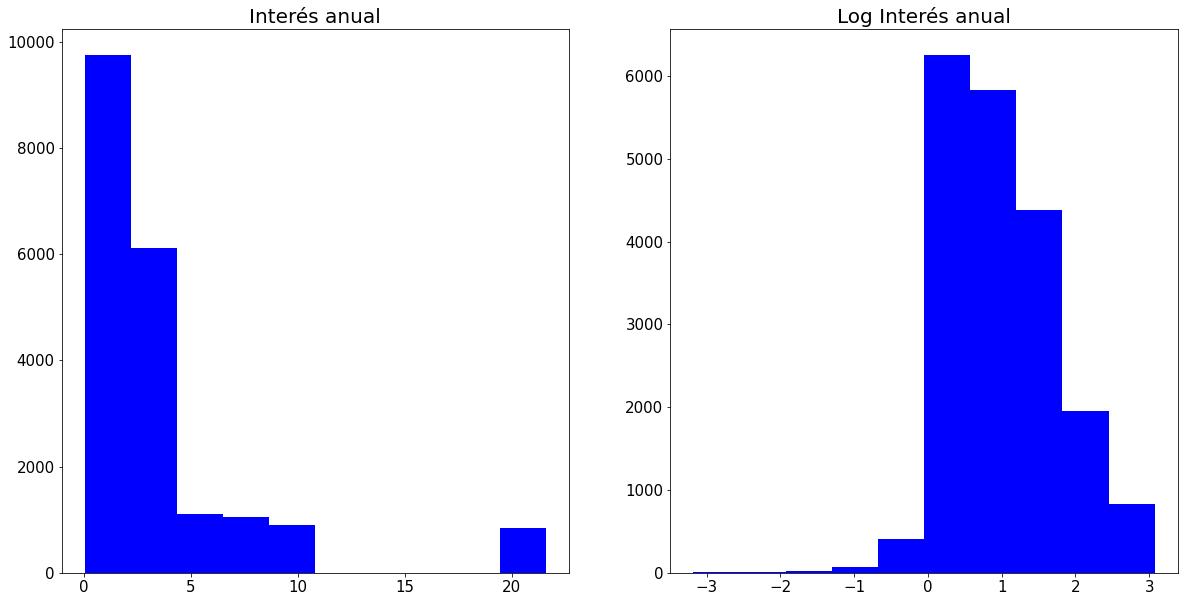

In [81]:
ll = (
    df_model
    .assign(
        # annual_interest_rate_per_sqrt = lambda k: np.sqrt(k.annual_interest_rate_per),
        annual_interest_rate_per_log = lambda k: np.log(k.annual_interest_rate_per)
    )
    [['annual_interest_rate_per_log', 'annual_interest_rate_per']]
    # .hist(bins=20, figsize=(20, 8))
);

#  histogram of annual_interest_rate_per and annual_interest_rate_per_log
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(ll.annual_interest_rate_per, bins=10, color="blue")
ax[0].set_title("Interés anual", fontsize=20)
ax[1].hist(ll.annual_interest_rate_per_log, bins=10, color="blue")
ax[1].set_title("Log Interés anual", fontsize=20)
# increase the tick size
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)

- loan_rate_salary

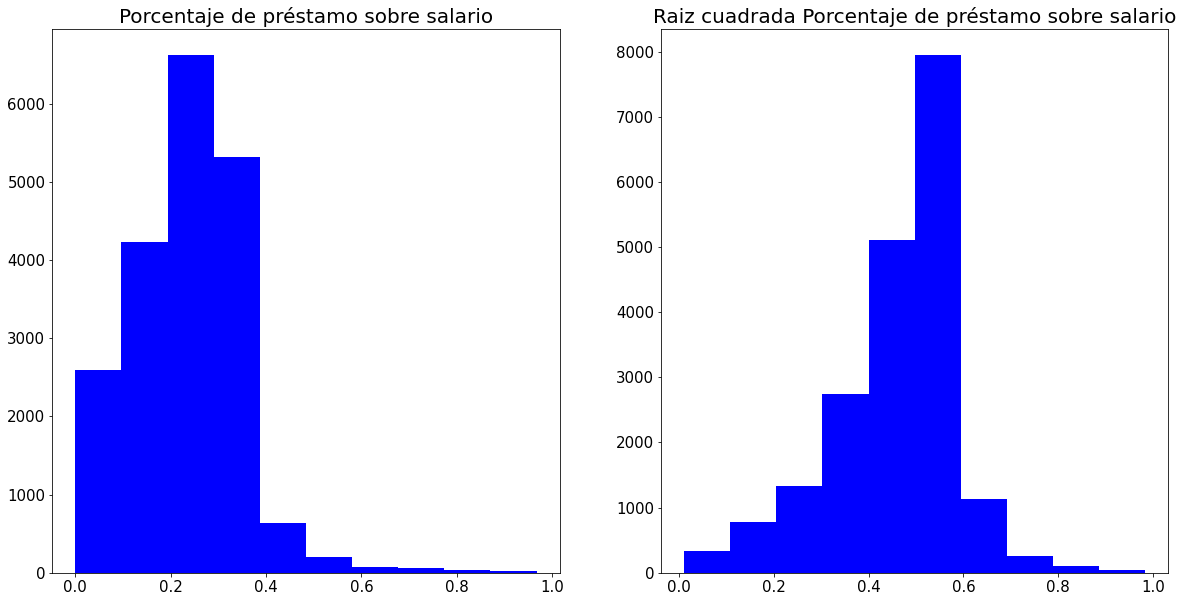

In [84]:
ll = (
    df_model
    .assign(loan_rate_salary_ = lambda k: np.sqrt(k.loan_rate_salary))
    [['loan_rate_salary_', 'loan_rate_salary']]
);

#  histogram of loan_rate_salary and loan_rate_salary_
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(ll.loan_rate_salary, bins=10, color="blue")
ax[0].set_title("Porcentaje de préstamo sobre salario", fontsize=20)
ax[1].hist(ll.loan_rate_salary_, bins=10, color="blue")
ax[1].set_title("Raiz cuadrada Porcentaje de préstamo sobre salario", fontsize=20)
# increase the tick size
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)

In [31]:
df_model = (
    df_model
    .assign(
        TimeInApp = lambda k: np.sqrt(k.TimeInApp),
        Age = lambda k: np.log(k.Age),
        paid_amount = lambda k: np.log(k.paid_amount + 1),
        loan_num = lambda k: np.sqrt(k.loan_num),
        annual_interest_rate_per = lambda k: np.log(k.annual_interest_rate_per),
        loan_rate_salary = lambda k: np.sqrt(k.loan_rate_salary)
    )
)

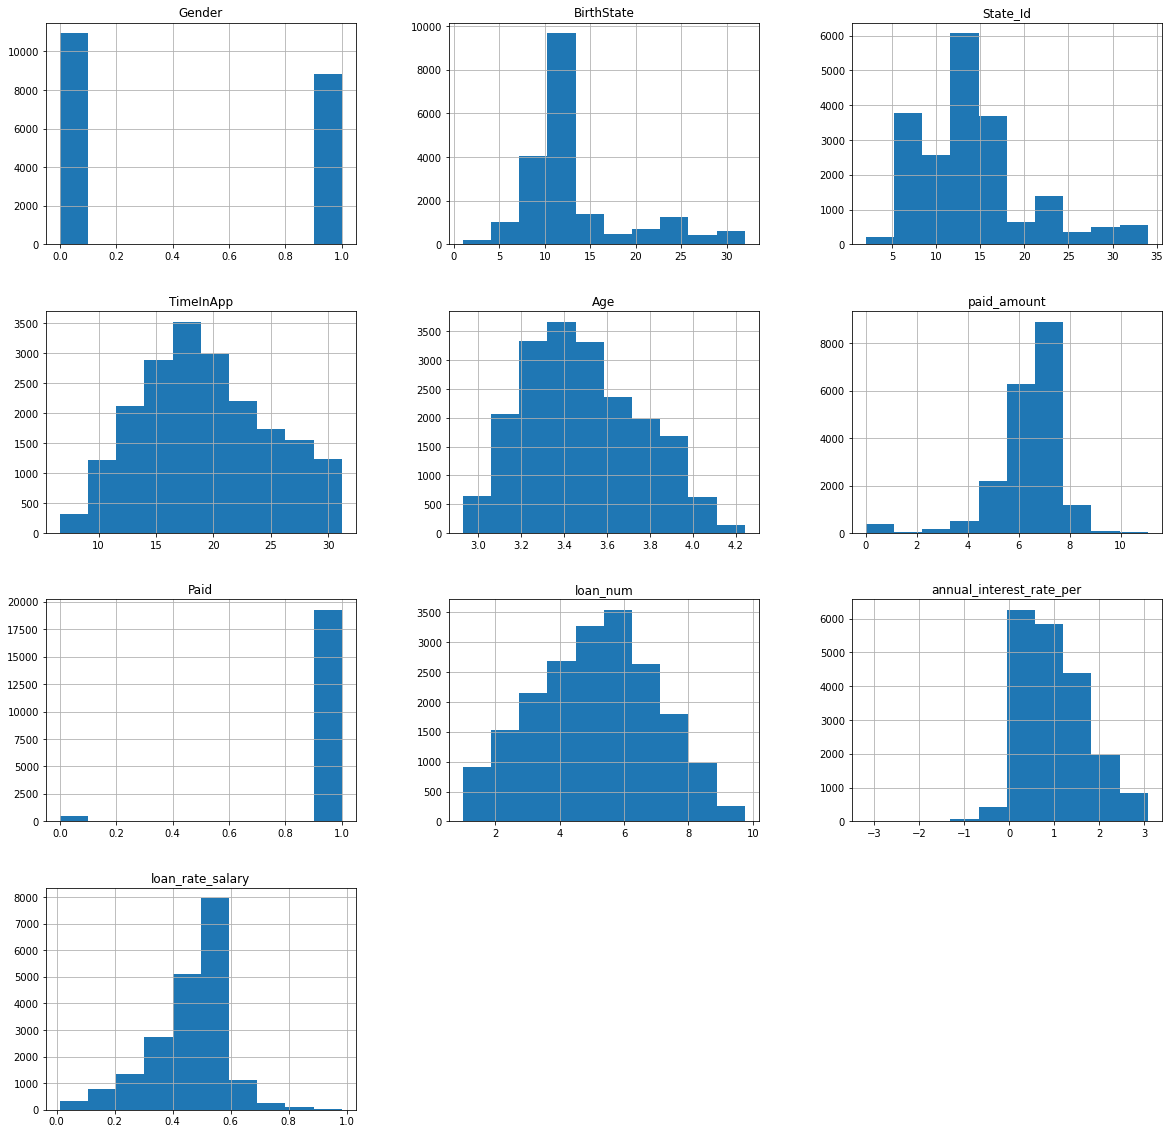

In [32]:
df_model.hist(figsize=(20, 20));

In [33]:
df_model.describe()
# These variables need standarization:
    # TimeInApp
    # Age
    # paid_amount
    # loan_num
    # annual_interest_rate_per
    # loan_rate_salary

,Gender,BirthState,State_Id,TimeInApp,Age,paid_amount,Paid,loan_num,annual_interest_rate_per,loan_rate_salary
count,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19769.000000,19770.000000
mean,0.446434,13.165857,14.199494,19.280951,3.488211,6.397296,0.973091,5.122855,1.022761,0.462910
std,0.497135,5.677897,5.937708,5.532923,0.269432,1.347757,0.161823,1.872702,0.754034,0.132813
min,0.000000,1.000000,2.000000,6.633250,2.927912,0.000000,0.000000,1.000000,-3.177282,0.011108
25%,0.000000,8.000000,11.000000,15.231546,3.283517,5.983980,1.000000,3.741657,0.433636,0.393281
50%,0.000000,13.000000,14.000000,18.788294,3.458437,6.673841,1.000000,5.196152,0.875469,0.491984
75%,1.000000,13.000000,15.000000,23.237900,3.679113,7.130275,1.000000,6.557439,1.463255,0.556054
max,1.000000,32.000000,34.000000,31.160873,4.242867,11.069400,1.000000,9.746794,3.072693,0.983483


#### 10.4 - Create categorical varibles

In [34]:
# This variables need to be inputed as categorical:
    # State_Id
    # BirthState

In [35]:
def pd_col_to_dummy(df, col):
    df_dummy = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, df_dummy], axis=1)
    df = df.drop(col, axis=1)
    return df

### 11.0 Last checks

In [36]:
df_model = df_model.dropna()

In [38]:
df_model = downcast(df_model)

In [39]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19769 entries, 0 to 19814
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    19769 non-null  int8   
 1   BirthState                19769 non-null  uint8  
 2   State_Id                  19769 non-null  uint8  
 3   TimeInApp                 19769 non-null  float32
 4   Age                       19769 non-null  float32
 5   paid_amount               19769 non-null  float32
 6   Paid                      19769 non-null  uint8  
 7   loan_num                  19769 non-null  float32
 8   annual_interest_rate_per  19769 non-null  float32
 9   loan_rate_salary          19769 non-null  float32
dtypes: float32(6), int8(1), uint8(3)
memory usage: 695.0 KB


### Save data

In [40]:
df_model.to_csv("Reporte de Anticipo Propuesta.csv", index=False)

In [43]:
pd.read_csv("Reporte de Anticipo Propuesta.csv")

,Gender,BirthState,State_Id,TimeInApp,Age,paid_amount,Paid,loan_num,annual_interest_rate_per,loan_rate_salary
0,0,13,14,11.661903,3.813741,3.849935,1,1.732051,0.770108,0.024546
1,0,11,11,11.445523,3.754380,8.684492,1,7.745967,0.770108,0.553064
2,0,8,7,11.618950,3.885022,7.019949,1,2.000000,0.770108,0.163524
3,1,13,14,10.295630,3.465479,4.423169,1,1.000000,0.770108,0.125122
4,0,13,14,10.198039,3.644872,7.206896,1,6.557438,0.770108,0.546901
...,...,...,...,...,...,...,...,...,...,...
19764,1,8,16,22.847319,3.491746,6.078399,1,4.690416,0.875469,0.570923
19765,0,13,14,30.724583,3.246499,4.862522,1,6.928203,0.875469,0.141390
19766,1,13,14,30.659420,3.167388,6.693918,1,4.690416,0.875469,0.462012
19767,0,27,28,16.703293,3.352626,4.671800,1,1.414214,0.875469,0.366256
